##### Our aim is to create a pre-trainer whose weights will be used to train our RqPINN

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
import pandas as pd  #for the moving average
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

#!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Problem
Solving the TISE, involves $V$'s with different values that can be very large at some points. If the potential $V(x)$ is large, it strongly affects the eigenfunctions and eigenvalues, typically causing eigenfunctions to localize in regions of lower potential and pushing eigenvalues higher.



### Solution

We approach the problem by first training a network to approximate simpler Gaussian functions with random means and variances or some Gaussian-Modulated Polynomial Basis functions. Subsequently we fine-tune (transfer) this knowledge to approximate more the eigenfunctions of the Schrödinger’s equation. Starting with simpler Gaussian shapes can give our model a stable, well-defined baseline for shape approximation and prevents the eigenvalue explosions.

In [2]:
#The sine activation function is also used here
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Defining the hyperparameters
t0 =-20; tf = 20; xbc = 0; gauss_num = 20
layers = [1,512,512,256,256,128,gauss_num]
col_pts = 100000; lr = 1e-3; epochs =40000

In [3]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [4]:
#initializing the model
model = qNN(layers)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=20, bias=True)
  )
)


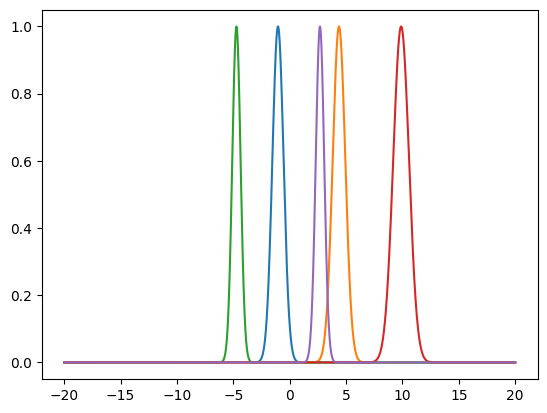

torch.Size([100000, 20])

In [5]:
#The gaussian function
def gaussian(t, mus, sigmas):
    gaussians = [torch.exp(-((t - mu)**2) / sigma**2) for mu, sigma in zip(mus, sigmas)]
    return torch.cat(gaussians, dim=1)  # shape (n, k)

t_test = torch.linspace(t0,tf, col_pts).view(-1,1) #For plotting
mus = torch.tensor(-10 + (10 + 10)*lhs(1,gauss_num)).view(-1,1) #Random means between [-10,10]
sigmas = torch.tensor(0.5 + (1.0 - 0.5)*lhs(1,gauss_num)).view(-1,1) #Random std's between [0.5,1.0]
target = gaussian(t_test, mus, sigmas)  

for i in range(5):
    plt.plot(t_test, target[:,i])
plt.show()
target.shape

In [6]:
def gauss_train(NN,target, t, epochs):
    t_rand = t.to(device).float()
    t_rand.requires_grad =True
    loss_list = []
    stime = time.time()
    for iter in range(epochs +1):
        optimizer.zero_grad()
        loss = 0.0
        #Getting the solution
        psi = NN(t_rand)
        Loss = torch.nn.MSELoss()
        loss = Loss(psi.float(),target.float())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()

        if iter % 2000 == 0:
            print(f"Epoch {iter}, Loss: {loss.item():.10f}")

    ftime = time.time()
    ttime = (ftime - stime)/60
    print(f'Total training time is {ttime} minutes')
    return NN, loss_list

In [ ]:
#Defining the predictor neural network for the gaussian
t_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1)
target = gaussian(t_lhs, mus, sigmas).to(device)
pre_trainer, pre_trainer_losses  = gauss_train(model,target,t_lhs, epochs)

Epoch 0, Loss: 0.14087012
Epoch 2000, Loss: 0.00049893
Epoch 4000, Loss: 0.00006398
Epoch 6000, Loss: 0.00001225
Epoch 8000, Loss: 0.00000372
Epoch 10000, Loss: 0.00000165
Epoch 12000, Loss: 0.00000094
Epoch 14000, Loss: 0.00000061
Epoch 16000, Loss: 0.00000043
Epoch 18000, Loss: 0.00000032
Epoch 20000, Loss: 0.00000024
Epoch 22000, Loss: 0.00000020
Epoch 24000, Loss: 0.00000016
Epoch 26000, Loss: 0.00000013
Epoch 28000, Loss: 0.00000011
Epoch 30000, Loss: 0.00000009
Epoch 32000, Loss: 0.00000008
Epoch 34000, Loss: 0.00000007
Epoch 36000, Loss: 0.00000006
Epoch 38000, Loss: 0.00000005
Epoch 40000, Loss: 0.00000005
Total training time is 17.578915055592855 minutes


In [7]:
#Just validating a saved model
checkpoint = torch.load('checkpoints/pre_trainer_no_ortho.pth', map_location=torch.device('cuda'))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

Pretrainer_loss = checkpoint["loss"]

 Test loss is: 0.000000, test shape: torch.Size([100000, 20])


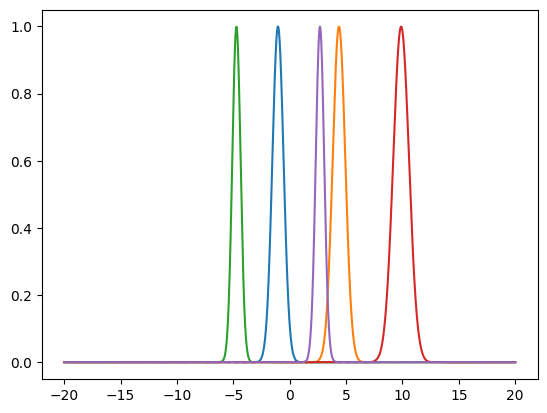

In [9]:
#Evaluating the model performance
model.eval()
with torch.no_grad():
    t = t_test.to(device)
    target_test = gaussian(t, mus.to(device), sigmas.to(device)).to(device)
    psi_hat = model(t)
    loss = torch.nn.MSELoss()(psi_hat, target_test)
    print(f" Test loss is: {loss.item():6f}, test shape: {psi_hat.shape}")
    mus = mus.cpu(); sigmas = sigmas.cpu()

    for i in range(5):
        plt.plot(t.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$mu$ = {mus[i].item()}, $sigma$ = {sigmas[i].item()}")
    plt.show()

In [ ]:
# Create a checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': pre_trainer_losses,  # your final loss value if you want to save it
}

import os
# Make the directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

torch.save(checkpoint, 'checkpoints/pre_trainer_no_ortho.pth')

### Gaussian-Modulated Polynomial Basis Functions.
We construct a family of basis functions by modulating polynomials with a Gaussian envelope. Each basis function is formed as the product of a Gaussian function and a polynomial having prescribed roots near the origin. Specifically, given a fixed grid over the domain, the basis functions take the form
\begin{equation}
\phi_n(x) = \exp\left( -\left(\frac{x}{s_n}\right)^2 \right) P_n(x),
\end{equation}
where $P_n(x)$ is a degree-n polynomial with roots chosen near the center of the domain, and $s_n$ controls the width of the Gaussian envelope. This construction ensures localization of the basis functions around the origin while allowing increasing oscillatory behavior with higher degrees. These Gaussian-modulated functions are particularly useful in applications requiring localized, yet flexible, function representations, such as spectral methods, function approximation, and reduced-order modeling.

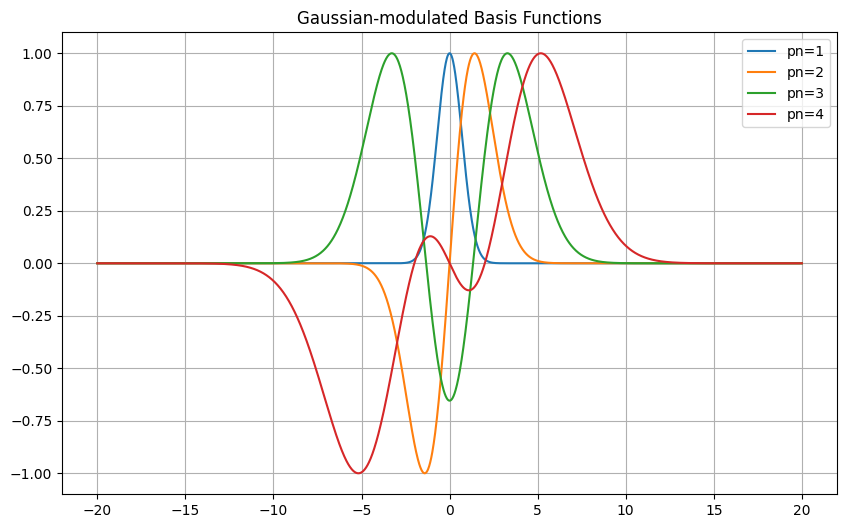

In [67]:
def fg(x, s):
    """Gaussian-like function."""
    return torch.exp(-(x/s)**2) #Creates a gaussian function with increasing widths

def build_function(xd, pn):
    """Builds the InFun(x) for given pn."""
    n = pn - 1 #INdicated the number of roots for the gaussian
    ftmp = fg(xd, pn)  # Gaussian with width pn

    if pn == 1:
        mfun = torch.ones_like(xd)  # The modulating function that causes the gaussian to cross zero
    else:
        sp = 40 / pn    #Spacing parameter
        pnt = (torch.arange(1, n+1) * sp - 20) * 0.2  # Roots, sp spreads the points along the domain, -20 allows it to match the starting point, 0.2 is the scaling factor
        mfun = torch.ones_like(xd)
        for pm in range(n):
            mfun = mfun * (xd - pnt[pm])

    InFun = ftmp * mfun
    InFun = InFun / InFun.abs().max()  # Normalize
    return InFun

def main():
    xd = torch.linspace(-20, 20, 2001)
    NMax = 4

    plt.figure(figsize=(10,6))
    for pn in range(1, NMax+1):
        InFun = build_function(xd, pn)
        plt.plot(xd.numpy(), InFun.numpy(), label=f'pn={pn}')
    
    plt.title('Gaussian-modulated Basis Functions')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [93]:
def fg(x, s):
    """Batch of Gaussians for different widths."""
    return torch.exp(-(x.unsqueeze(1) / s.unsqueeze(0)) ** 2)  # (n_points, n_functions)

def gauss_modulated_basis(xd, NMax):
    """Vectorized basis matrix construction."""
    n_points = xd.shape[0]
    pn = torch.arange(1, NMax+1)  # (NMax,)
    n = pn - 1  # (NMax,)

    # Build Gaussian part (n_points, NMax)
    gaussian = fg(xd, pn)

    # Build modulation polynomial part
    mfun = torch.ones((n_points, NMax))

    for idx in range(NMax):
        degree = n[idx]
        if degree > 0:
            sp = (tf-t0) / pn[idx]
            pnt = (torch.arange(1, degree+1) * sp + t0) * 0.2  # The roots 
            for pm in range(degree):
                mfun[:, idx] *= (xd - pnt[pm])

    # Multiply Gaussian × Polynomial
    basis = gaussian * mfun

    # Normalize each column
    basis = basis / basis.abs().max(dim=0, keepdim=True).values  # Normalize each basis function

    return basis


In [104]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()

#We generate the basis using lhs, but we sort to ensure that uniformity
xlhs_sort,idx = torch.sort(x_lhs.squeeze(1))
gm_basis = gauss_modulated_basis(xlhs_sort, gauss_num)
gm_basis_lhs = gm_basis[torch.argsort(idx), :] #To unsort i.e make the index match that of x_lhs

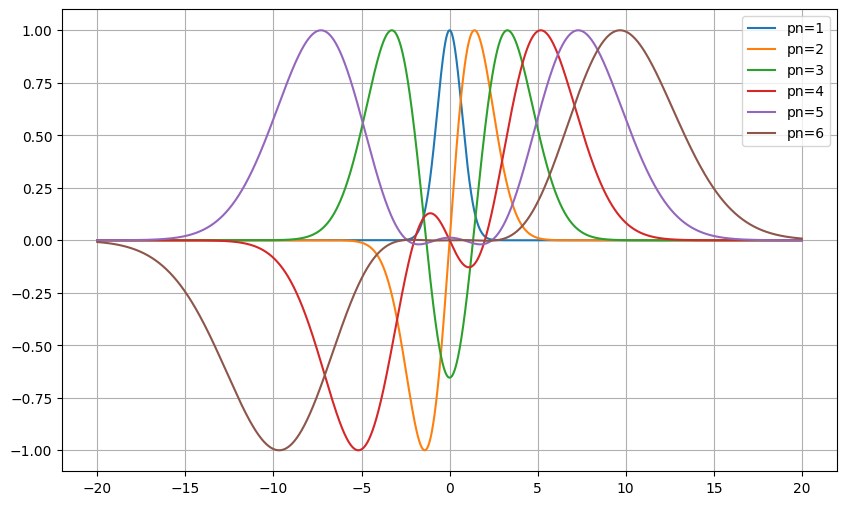

In [105]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.plot(xlhs_sort.numpy(), gm_basis[:, i].numpy(), label=f'pn={i+1}')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
#We want to find the best lr for our defined model
model_lr = qNN(layers)
model_lr.to(device)
optimizer = optim.Adam(model_lr.parameters(), lr=1e-7, betas = betas)
criterion = nn.MSELoss()

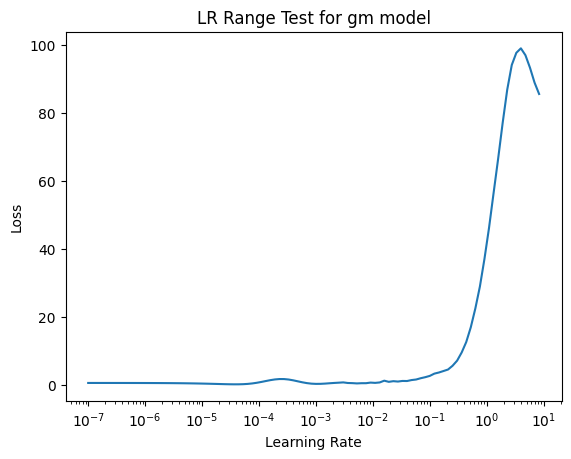

In [102]:
xd = x_lhs.to(device) ; gm_basis = gm_basis_lhs.to(device)

# Set up variables
losses = []
lrs = []

start_lr = 1e-7
end_lr = 10
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer.param_groups[0]['lr'] = lr

    optimizer.zero_grad()
    phi = model_lr(xd)
    loss = criterion(phi.float(),gm_basis.float())
    loss.backward()

    optimizer.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test for gm model')
plt.show()


In [106]:
#From this plot, we will be selecting lr = 1e-3
#Now we initialize the model
gm_model = qNN(layers)
gm_model.to(device)
print(gm_model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(gm_model.parameters(), lr=1e-4, betas=betas)
#Scheduler

#scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [107]:
gm_basis_lhs = gm_basis_lhs.to(device)
gm_pre_trainer, gm_pre_trainer_losses  = gauss_train(gm_model,gm_basis_lhs,x_lhs, epochs)

Epoch 0, Loss: 0.4861133397
Epoch 2000, Loss: 0.0029968515
Epoch 4000, Loss: 0.0004985054
Epoch 6000, Loss: 0.0001076768
Epoch 8000, Loss: 0.0000415308
Epoch 10000, Loss: 0.0000195910
Epoch 12000, Loss: 0.0000111895
Epoch 14000, Loss: 0.0000075387
Epoch 16000, Loss: 0.0000055015
Epoch 18000, Loss: 0.0000041370
Epoch 20000, Loss: 0.0000031617
Epoch 22000, Loss: 0.0000024355
Epoch 24000, Loss: 0.0000018855
Epoch 26000, Loss: 0.0000014689
Epoch 28000, Loss: 0.0000011552
Epoch 30000, Loss: 0.0000009187
Epoch 32000, Loss: 0.0000007382
Epoch 34000, Loss: 0.0000005975
Epoch 36000, Loss: 0.0000004856
Epoch 38000, Loss: 0.0000003956
Epoch 40000, Loss: 0.0000003230
Total training time is 18.610619286696117 minutes


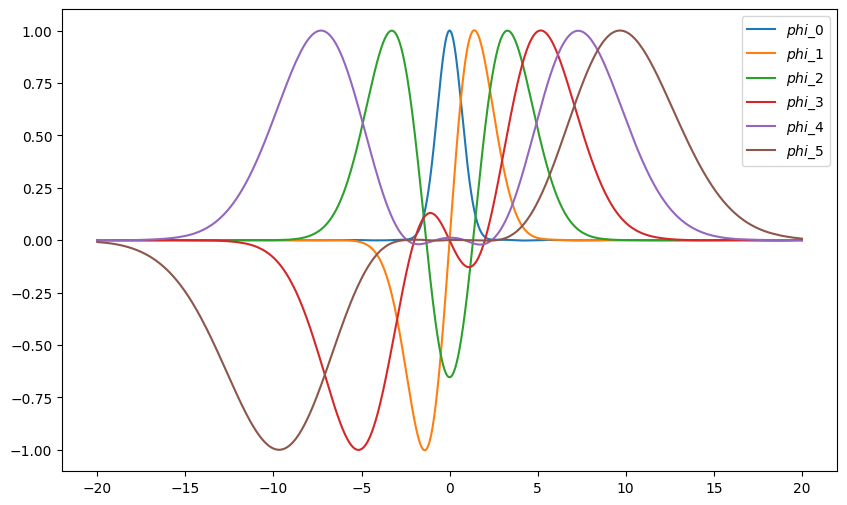

In [117]:
#Evaluating the model performance
plt.figure(figsize=(10,6))
gm_model.eval()
x_lhs_sort = xlhs_sort.unsqueeze(1).to(device)
with torch.no_grad():
    psi_hat = gm_model(x_lhs_sort)
    for i in range(6):
        plt.plot(x_lhs_sort.cpu().numpy(), psi_hat[:,i].cpu().numpy(), label=f"$phi$_{i}")
    plt.legend()
    plt.show()

In [118]:
# Create a checkpoint dictionary
checkpoint = {
    'model_state_dict': gm_pre_trainer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': gm_pre_trainer_losses,  # your final loss value if you want to save it
}

import os
# Make the directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

torch.save(checkpoint, 'checkpoints/gauss_modulated_pre_trainer.pth')